# 18-819 QML Project running QVC to QiSkit

In [26]:
# Use Braket SDK Cost Tracking to estimate cost
from braket.tracking import Tracker
t = Tracker().start()

### Accessing Quantum Processing Units

We will access third party QPUs to run our training on quantum hardware. 



In [27]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()

# Seeing which QPUs are online
provider.backends(statuses=["ONLINE"], types=["QPU"])


[]

In [28]:
# qpu_backend = provider.get_backend("Aria 1")

# print(qpu_backend)

In [29]:
from qiskit_ibm_runtime import QiskitRuntimeService
# token = "5fda91fd4ae9fb270f2589d266bd22dc3f09166017a24200f05b06d521e228583779e1d2681bb29cbba459b5c24c5a4102894b11e22de77c85448ca28ea4e9fd"
token = "363e3e6f5bc93bbecd915738efc09260cadfd6855e80efbf7fc0854951de819cb598c44db006cfd64e5df56c58a344de0d267905b6e4b9c25e8ab2bc2fead5cd"
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True
)
 

In [30]:

# After using the following code, go to your dashboard (https://quantum.ibm.com/)
# and expire your API token (click the refresh button in the API token field)
# service = QiskitRuntimeService(channel="ibm_quantum", token=token)
# backend = service.least_busy(operational=True, simulator=False)


In [31]:
# from qiskit import QuantumCircuit
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
 
# # Create empty circuit
# example_circuit = QuantumCircuit(2)
# example_circuit.measure_all()
 
# # You'll need to specify the credentials when initializing QiskitRuntimeService, if they were not previously saved.
# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False)
 
# sampler = Sampler(backend)
# job = sampler.run([example_circuit])
# print(f"job id: {job.job_id()}")
# result = job.result()
# print(result)

### Loading the Exoplanet training data

The exoplanet training data has already been separated into X_train, X_test, y_train, y_test. 

We will use it for the training


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
# X_train = np.loadtxt('middle_data/X_train.txt', delimiter=' ')
# X_test  = np.loadtxt('middle_data/X_test.txt', delimiter=' ')

# Y_train = np.loadtxt('middle_data/Y_train.txt', delimiter=' ')
# Y_test  = np.loadtxt('middle_data/Y_test.txt', delimiter=' ')

data = np.loadtxt('planet.txt', delimiter=',', dtype=float)

X_train = data[:2000, :-1]
Y_train = data[:2000, -1]

X_test = data[2000:3000, :-1]
Y_test = data[2000:3000, -1]


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (2000, 37)
X_test shape: (1000, 37)
Y_train shape: (2000,)
Y_test shape: (1000,)


In [34]:
print(type(X_train))

<class 'numpy.ndarray'>


### 1. Data pre-processing 

In this step, we will perform normalization of the X dataset, and label y in binary terms

In [35]:
!/home/ec2-user/anaconda3/envs/Braket/bin/python -m pip install scikit-learn pylatexenc

/bin/bash: line 1: /home/ec2-user/anaconda3/envs/Braket/bin/python: No such file or directory


In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Dimensionality reduction
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Normalize data to the range [-1, 1] (use the training set to fit the scaler)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure labels are binary (if not already binary)
Y_train = (Y_train > np.median(Y_train)).astype(int)
Y_test = (Y_test > np.median(Y_test)).astype(int)

print(f"X_train shape after selection: {X_train.shape}")
print(f"X_test shape after selection: {X_test.shape}")

X_train shape after selection: (2000, 2)
X_test shape after selection: (1000, 2)


In [37]:
np.min(X_train)

-1.0

In [38]:
X_train[0], Y_train[0]

(array([-0.99970882, -0.07410542]), 0)

Encoding the data into quantum states

### 2. Defining the ZZFeatureMap

The ZZFeatureMap encodes the classical data into a quantum state. The depth determines the number of repeated layers in the feature map.

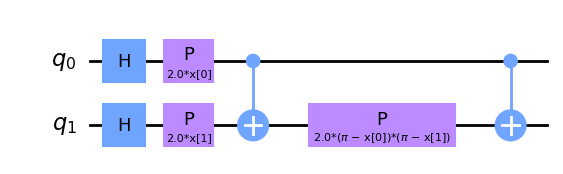

In [7]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap

# num_features = X_train.shape[1]
num_features = 2
feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1, entanglement='linear')
# feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1, entanglement='linear')
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)


In [40]:
# https://docs.quantum.ibm.com/guides/transpile
# https://docs.quantum.ibm.com/guides/transpile-with-pass-managers
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

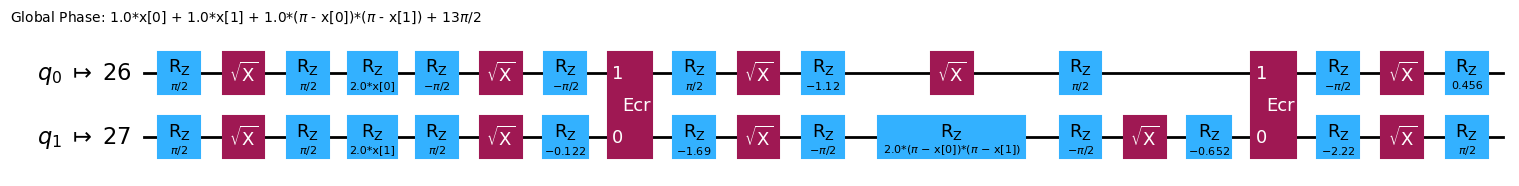

In [41]:
transpiled_feature_map = pass_manager.run(feature_map)
transpiled_feature_map.draw("mpl", idle_wires=False)

### 3. Define a variational Ansatz

The variational ansatz applies trainable gates to the quantum state produced by the feature map.

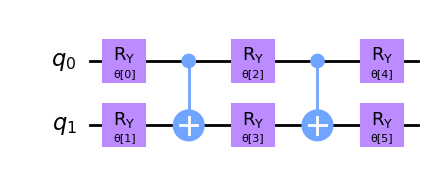

In [42]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=2, entanglement='linear')
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

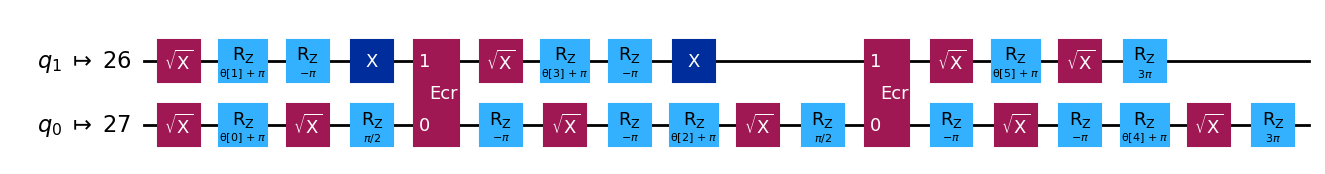

In [43]:
transpiled_ansatz = pass_manager.run(ansatz)
transpiled_ansatz.draw("mpl", idle_wires=False)

### 4. Define the Model: Variational Quantum Classifier

Use the VQC (Variational Quantum Classifier) from Qiskit's machine learning module.

Documentation: https://qiskit-community.github.io/qiskit-machine-learning/_modules/qiskit_machine_learning/algorithms/classifiers/vqc.html


In [44]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler


from tqdm import tqdm

# Initialize the optimizer
optimizer = COBYLA(maxiter=100)

# Initialize the Sampler primitive
# sampler = Sampler(backend) #StatevectorSampler() #backend=qpu_backend)
sampler = StatevectorSampler()

# Defining a callback to see the iteration
def verbose_callback(weights, objective_value):
    """
    Verbose callback function to monitor the training process during fit.

    Args:
        weights (np.ndarray): Current variational circuit parameters.
        objective_value (float): Current loss value.
    """
    print(f"Iteration: Objective Value = {objective_value:.4f}, Weights = {weights}")

# Initialize a global progress bar
progress_bar = tqdm(total=100, desc="Training Progress")  # Replace 100 with your optimizer's max iterations

def tqdm_callback(weights, objective_value):
    """
    Callback function to update the tqdm progress bar during training.

    Args:
        weights (np.ndarray): Current variational circuit parameters.
        objective_value (float): Current value of the loss function.
    """
    progress_bar.update(1)
    progress_bar.set_postfix({"Loss": objective_value})

# Build the Quantum Variational Classifier
# Num Qubits is specified as None, so that we just use the number of qubits
# specified by the quantum feature map

# vqc = VQC(feature_map=transpiled_feature_map, 
#           ansatz=transpiled_ansatz, 
#           optimizer=optimizer,
#           loss="cross_entropy", # default
#           sampler=sampler,
#           callback=tqdm_callback,  
#          )

vqc = VQC(feature_map=feature_map, 
          ansatz=ansatz, 
          optimizer=optimizer,
          loss="cross_entropy", # default
          sampler=sampler,
          callback=tqdm_callback,  
         )


Training Progress:   3%|▎         | 3/100 [4:54:01<158:26:32, 5880.33s/it, Loss=2.25]


### 5. Train the VQC

Now we will start training the quantum circuit

In [45]:
print(backend.configuration())


In [46]:
batch_size = 200

# Split data into batches
data_batches = [
    (X_train[i:i+batch_size], Y_train[i:i+batch_size])
    for i in range(0, len(X_train), batch_size)
]

In [47]:
x_batch, y_batch = data_batches[0]
print(x_batch.shape, y_batch.shape)
print(X_train.shape, Y_train.shape)
y_batch

(200, 2) (200,)
(2000, 2) (2000,)


array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1])

In [48]:
for x_batch, y_batch in data_batches:
    print(x_batch.shape, y_batch.shape)
    vqc.fit(x_batch, y_batch)

(200, 2) (200,)


Training Progress:  59%|█████▉    | 59/100 [02:19<01:03,  1.56s/it, Loss=0.957]

(200, 2) (200,)


Training Progress: 136it [04:09,  1.33s/it, Loss=0.957]                         

(200, 2) (200,)


Training Progress: 201it [05:40,  1.40s/it, Loss=0.96] 

(200, 2) (200,)


Training Progress: 261it [07:02,  1.38s/it, Loss=0.966]

(200, 2) (200,)


Training Progress: 323it [08:27,  1.38s/it, Loss=0.972]

(200, 2) (200,)


Training Progress: 396it [10:39,  1.90s/it, Loss=0.916]

(200, 2) (200,)


Training Progress: 469it [12:39,  1.46s/it, Loss=0.935]

(200, 2) (200,)


Training Progress: 532it [14:08,  1.59s/it, Loss=0.963]

(200, 2) (200,)


Training Progress: 599it [15:58,  1.28s/it, Loss=0.926]

(200, 2) (200,)


Training Progress: 672it [17:49,  1.42s/it, Loss=0.957]

In [49]:
# vqc.fit(X_train, Y_train)


### 6. Testing of the VQC

Here, we will figure out the accuracy of the VQC, both on the train set and the test set. 


In [50]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_test, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.61
Quantum VQC on the test dataset:     0.61
